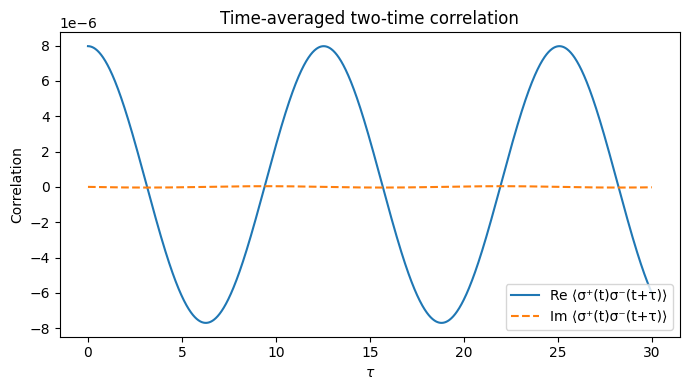

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Parameters 
tau_decay = 0.05
k = np.pi / 2
A0 = 0.2
omega = 0.501

Epk = 1.0
dEpk = 0.6
App = 0.2

#Drive
def A_t(t):
    return A0 * np.sin(omega * t)

def hz(t):
    A = A_t(t)
    return (
        Epk
        - dEpk * np.cos(k) * np.sin(A)
        - 2 * Epk * App * (1 - np.cos(A))
    )

def hy(t):
    A = A_t(t)
    return (
        dEpk * np.sin(k) * (1 - np.cos(A))
        - 2 * Epk * App * np.sin(A)
    )

#Bloch matrix
def B_matrix(t):
    return np.array([
        [-(1/tau_decay + 2j*hz(t)), 0.0, hy(t)],
        [0.0, -(1/tau_decay - 2j*hz(t)), hy(t)],
        [-2*hy(t), -2*hy(t), -2/tau_decay]
    ], dtype=complex)

b1 = np.array([0.0, 0.0, -2/tau_decay], dtype=complex)

#ODE wrapper
def odes_real(t, y):
    y_c = y[:3] + 1j*y[3:]
    dydt = B_matrix(t) @ y_c + b1
    return np.concatenate([dydt.real, dydt.imag])

#steady state ⟨σ⟩
c0 = np.array([0.0, 0.0, -1.0], dtype=complex)
y0 = np.concatenate([c0.real, c0.imag])

T = 75
t_eval = np.linspace(0, T, 6000)

sol = solve_ivp(
    odes_real, [0, T], y0,
    t_eval=t_eval, rtol=1e-9, atol=1e-12
)

c = sol.y[:3] + 1j*sol.y[3:]
sigma_m = c[0]
sigma_p = c[1]
sigma_z = c[2]
t = sol.t

#keep one steady-state period
T_drive = 2*np.pi / omega
t0 = T - T_drive
mask_t = t >= t0

t_vals = t[mask_t]
sigma_p_vals = sigma_p[mask_t]
sigma_z_vals = sigma_z[mask_t]

#evolve in τ
tau_max = 30
tau_eval = np.linspace(0, tau_max, 1500)

C_tau = []

for ti, sp, sz in zip(t_vals, sigma_p_vals, sigma_z_vals):

    # modified initial condition at τ=0
    C0 = np.array([
        0.5 * (1 + sz),   # <σ+σ->
        0.0,              # <σ+σ+>
        -sp               # <σ+σz>
    ], dtype=complex)

    y0_tau = np.concatenate([C0.real, C0.imag])

    def corr_odes(tau, y):
        y_c = y[:3] + 1j*y[3:]
        dydt = B_matrix(ti + tau) @ y_c + np.array([0, 0, -2/tau_decay * sp])
        return np.concatenate([dydt.real, dydt.imag])

    sol_tau = solve_ivp(
        corr_odes, [0, tau_max], y0_tau,
        t_eval=tau_eval, rtol=1e-8, atol=1e-11
    )

    C = sol_tau.y[:3] + 1j*sol_tau.y[3:]
    C_tau.append(C[0])   # <σ+(t) σ-(t+τ)>

C_tau = np.array(C_tau)

#time-averaged correlation
C_avg = np.mean(C_tau, axis=0)

# Plot result
plt.figure(figsize=(7,4))
plt.plot(tau_eval, C_avg.real, label='Re ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.plot(tau_eval, C_avg.imag, '--', label='Im ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.xlabel(r'$\tau$')
plt.ylabel('Correlation')
plt.title('Time-averaged two-time correlation')
plt.legend()
plt.tight_layout()
plt.show()


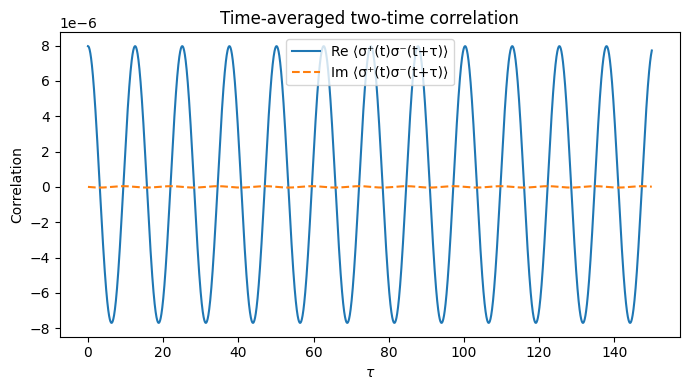

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Parameters 
tau_decay = 0.05
k = np.pi / 2 #Fixed momentum k
A0 = 0.2
omega = 0.501

Epk = 1.0
dEpk = 0.6
App = 0.2

#Drive
def A_t(t):
    return A0 * np.sin(omega * t)

def hz(t):
    A = A_t(t)
    return (
        Epk
        - dEpk * np.cos(k) * np.sin(A)
        - 2 * Epk * App * (1 - np.cos(A))
    )

def hy(t):
    A = A_t(t)
    return (
        dEpk * np.sin(k) * (1 - np.cos(A))
        - 2 * Epk * App * np.sin(A)
    )

#Bloch matrix
def B_matrix(t):
    return np.array([
        [-(1/tau_decay + 2j*hz(t)), 0.0, hy(t)],
        [0.0, -(1/tau_decay - 2j*hz(t)), hy(t)],
        [-2*hy(t), -2*hy(t), -2/tau_decay]
    ], dtype=complex)

b1 = np.array([0.0, 0.0, -2/tau_decay], dtype=complex)

#ODE wrapper
def odes_real(t, y):
    y_c = y[:3] + 1j*y[3:]
    dydt = B_matrix(t) @ y_c + b1
    return np.concatenate([dydt.real, dydt.imag])

#steady state ⟨σ⟩
c0 = np.array([0.0, 0.0, -1.0], dtype=complex)
y0 = np.concatenate([c0.real, c0.imag])

T = 75
t_eval = np.linspace(0, T, 6000)

sol = solve_ivp(
    odes_real, [0, T], y0,
    t_eval=t_eval, rtol=1e-9, atol=1e-12
)

c = sol.y[:3] + 1j*sol.y[3:]
sigma_m = c[0]
sigma_p = c[1]
sigma_z = c[2]
t = sol.t

#keep one steady-state period
T_drive = 2*np.pi / omega
t0 = T - T_drive
mask_t = t >= t0

t_vals = t[mask_t]
sigma_p_vals = sigma_p[mask_t]
sigma_z_vals = sigma_z[mask_t]

#evolve in τ
tau_max = 150
tau_eval = np.linspace(0, tau_max, 4000)

C_tau = []

for ti, sp, sz in zip(t_vals, sigma_p_vals, sigma_z_vals):

    #two-time correlation and modified initial condition at τ=0
    C0 = np.array([
        0.5 * (1 + sz),   # <σ+σ->
        0.0,              # <σ+σ+>
        -sp               # <σ+σz>
    ], dtype=complex)

    y0_tau = np.concatenate([C0.real, C0.imag])

#evolve in τ
    def corr_odes(tau, y):
        y_c = y[:3] + 1j*y[3:]
        dydt = B_matrix(ti + tau) @ y_c + np.array([0, 0, -2/tau_decay * sp])
        return np.concatenate([dydt.real, dydt.imag])

    sol_tau = solve_ivp(
        corr_odes, [0, tau_max], y0_tau,
        t_eval=tau_eval, rtol=1e-8, atol=1e-11
    )

    C = sol_tau.y[:3] + 1j*sol_tau.y[3:]
    C_tau.append(C[0])   # <σ+(t) σ-(t+τ)>

C_tau = np.array(C_tau)

#time-averaged correlation
C_avg = np.mean(C_tau, axis=0)

# Plot result
plt.figure(figsize=(7,4))
plt.plot(tau_eval, C_avg.real, label='Re ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.plot(tau_eval, C_avg.imag, '--', label='Im ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.xlabel(r'$\tau$')
plt.ylabel('Correlation')
plt.title('Time-averaged two-time correlation')
plt.legend()
plt.tight_layout()
plt.show()


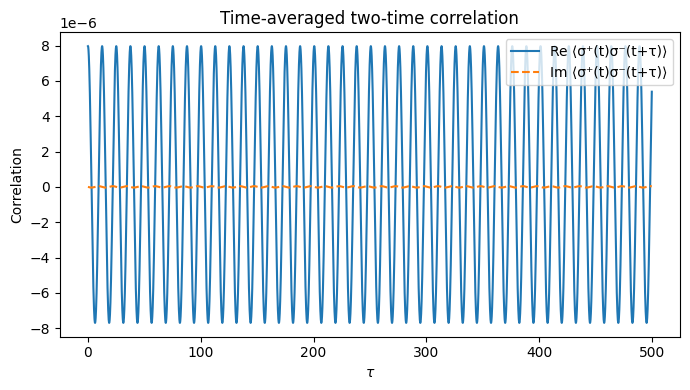

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Parameters 
tau_decay = 0.05
k = np.pi / 2
A0 = 0.2
omega = 0.501

Epk = 1.0
dEpk = 0.6
App = 0.2

#Drive
def A_t(t):
    return A0 * np.sin(omega * t)

def hz(t):
    A = A_t(t)
    return (
        Epk
        - dEpk * np.cos(k) * np.sin(A)
        - 2 * Epk * App * (1 - np.cos(A))
    )

def hy(t):
    A = A_t(t)
    return (
        dEpk * np.sin(k) * (1 - np.cos(A))
        - 2 * Epk * App * np.sin(A)
    )

#Bloch matrix
def B_matrix(t):
    return np.array([
        [-(1/tau_decay + 2j*hz(t)), 0.0, hy(t)],
        [0.0, -(1/tau_decay - 2j*hz(t)), hy(t)],
        [-2*hy(t), -2*hy(t), -2/tau_decay]
    ], dtype=complex)

b1 = np.array([0.0, 0.0, -2/tau_decay], dtype=complex)

#ODE wrapper
def odes_real(t, y):
    y_c = y[:3] + 1j*y[3:]
    dydt = B_matrix(t) @ y_c + b1
    return np.concatenate([dydt.real, dydt.imag])

#steady state ⟨σ⟩
c0 = np.array([0.0, 0.0, -1.0], dtype=complex)
y0 = np.concatenate([c0.real, c0.imag])

T = 75
t_eval = np.linspace(0, T, 6000)

sol = solve_ivp(
    odes_real, [0, T], y0,
    t_eval=t_eval, rtol=1e-9, atol=1e-12
)

c = sol.y[:3] + 1j*sol.y[3:]
sigma_m = c[0]
sigma_p = c[1]
sigma_z = c[2]
t = sol.t

#keep one steady-state period
T_drive = 2*np.pi / omega
t0 = T - T_drive
mask_t = t >= t0

t_vals = t[mask_t]
sigma_p_vals = sigma_p[mask_t]
sigma_z_vals = sigma_z[mask_t]

#evolve in τ
tau_max = 500
tau_eval = np.linspace(0, tau_max, 11300)

C_tau = []

for ti, sp, sz in zip(t_vals, sigma_p_vals, sigma_z_vals):

    # modified initial condition at τ=0
    C0 = np.array([
        0.5 * (1 + sz),   # <σ+σ->
        0.0,              # <σ+σ+>
        -sp               # <σ+σz>
    ], dtype=complex)

    y0_tau = np.concatenate([C0.real, C0.imag])

    def corr_odes(tau, y):
        y_c = y[:3] + 1j*y[3:]
        dydt = B_matrix(ti + tau) @ y_c + np.array([0, 0, -2/tau_decay * sp])
        return np.concatenate([dydt.real, dydt.imag])

    sol_tau = solve_ivp(
        corr_odes, [0, tau_max], y0_tau,
        t_eval=tau_eval, rtol=1e-8, atol=1e-11
    )

    C = sol_tau.y[:3] + 1j*sol_tau.y[3:]
    C_tau.append(C[0])   # <σ+(t) σ-(t+τ)>

C_tau = np.array(C_tau)

#time-averaged correlation
C_avg = np.mean(C_tau, axis=0)

# Plot result
plt.figure(figsize=(7,4))
plt.plot(tau_eval, C_avg.real, label='Re ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.plot(tau_eval, C_avg.imag, '--', label='Im ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.xlabel(r'$\tau$')
plt.ylabel('Correlation')
plt.title('Time-averaged two-time correlation')
plt.legend()
plt.tight_layout()
plt.show()

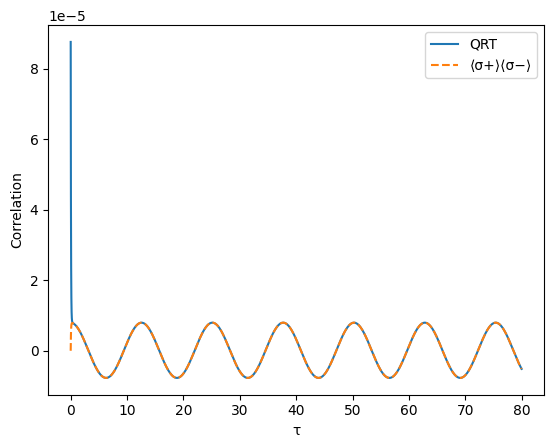

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


#parameters
tau_decay = 0.05
k = np.pi/2
A0 = 0.2
omega = 0.5

Epk = 1.0
dEpk = 0.6
App = 0.2

#Drive
def A(t):
    return A0*np.sin(omega*t)

def hz(t):
    return Epk - dEpk*np.cos(k)*np.sin(A(t)) - 2*Epk*App*(1-np.cos(A(t)))

def hy(t):
    return dEpk*np.sin(k)*(1-np.cos(A(t))) - 2*Epk*App*np.sin(A(t))

#bloch matrix
def B(t):
    return np.array([
        [-(1/tau_decay + 2j*hz(t)), 0, hy(t)],
        [0, -(1/tau_decay - 2j*hz(t)), hy(t)],
        [-2*hy(t), -2*hy(t), -2/tau_decay]
    ],dtype=complex)

b = np.array([0,0,-2/tau_decay],dtype=complex)

# ODE wrapper
def odes(t,y):
    y = y[:3] + 1j*y[3:]
    dy = B(t)@y + b
    return np.hstack([dy.real,dy.imag])

#find steady state
T = 100
t_eval = np.linspace(0,T,6000)
y0 = np.zeros(6)

#getting the steady state
sol = solve_ivp(odes,[0,T],y0,t_eval=t_eval)

c = sol.y[:3] + 1j*sol.y[3:]
sp = c[1]
sz = c[2]
t = sol.t

# keep one drive period
Td = 2*np.pi/omega
mask = t > (T-Td)
tvals = t[mask]
spvals = sp[mask]
szvals = sz[mask]

# Two-time QRT
tau = np.linspace(0,80,2000)
C_q = []

for ti,sp0,sz0 in zip(tvals,spvals,szvals):

    # σ+ρ initial condition
    C0 = np.array([0.5*(1+sz0),0,-sp0])
    y0t = np.hstack([C0.real,C0.imag])
    #evolve in tau
    def corr(tau,y):
        y = y[:3] + 1j*y[3:]
        dy = B(ti+tau)@y + np.array([0,0,-2/tau_decay*sp0])
        return np.hstack([dy.real,dy.imag])

    sol2 = solve_ivp(corr,[0,tau[-1]],y0t,t_eval=tau)
    C_q.append(sol2.y[0] + 1j*sol2.y[3])

C_q = np.mean(np.array(C_q),axis=0)

# Factorized average
C_f = []

for ti,sp0 in zip(tvals,spvals):

    y0a = np.hstack([[0,np.conj(sp0),sz0],[0,0,0]])

    def avg(tau,y):
        y = y[:3] + 1j*y[3:]
        dy = B(ti+tau)@y + b
        return np.hstack([dy.real,dy.imag])

    sol3 = solve_ivp(avg,[0,tau[-1]],y0a,t_eval=tau)
    sm = sol3.y[0] + 1j*sol3.y[3]
    C_f.append(sp0*sm)

C_f = np.mean(np.array(C_f),axis=0)

# Plot
plt.plot(tau,C_q.real,label="QRT")
plt.plot(tau,C_f.real,'--',label="⟨σ+⟩⟨σ−⟩")
plt.legend()
plt.xlabel("τ")
plt.ylabel("Correlation")
plt.show()



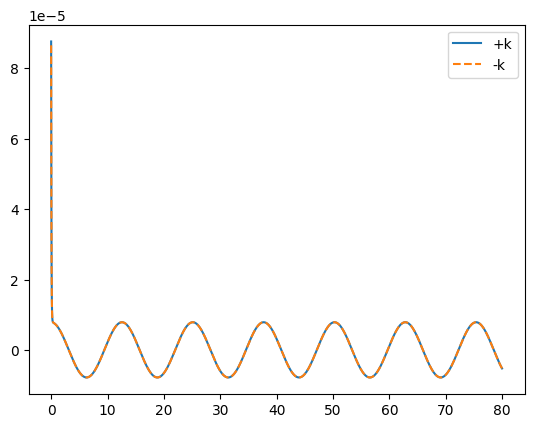

In [6]:
def run(kval):
    global k
    k = kval

    sol = solve_ivp(odes,[0,T],y0,t_eval=t_eval)
    c = sol.y[:3] + 1j*sol.y[3:]
    sp = c[1]
    sz = c[2]
    t = sol.t

    mask = t > (T-Td)
    tvals = t[mask]
    spvals = sp[mask]
    szvals = sz[mask]

    C = []
    for ti,sp0,sz0 in zip(tvals,spvals,szvals):
        C0 = np.array([0.5*(1+sz0),0,-sp0])
        y0t = np.hstack([C0.real,C0.imag])

        def corr(tau,y):
            y = y[:3] + 1j*y[3:]
            dy = B(ti+tau)@y + np.array([0,0,-2/tau_decay*sp0])
            return np.hstack([dy.real,dy.imag])

        sol2 = solve_ivp(corr,[0,tau[-1]],y0t,t_eval=tau)
        C.append(sol2.y[0] + 1j*sol2.y[3])

    return np.mean(np.array(C),axis=0)

Ck = run(np.pi/2)
Cmk = run(-np.pi/2)

plt.plot(tau,Ck.real,label="+k")
plt.plot(tau,Cmk.real,'--',label="-k")
plt.legend()
plt.show()
